<a href="https://www.kaggle.com/code/klyushnik/s5e11-ensemble-roc0-90862?scriptVersionId=278010418" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


# Welcome!

![What-Is-Loan-Repayment-Why-It-Is-Important-How-It-Works.jpg](https://www.wintwealth.com/blog/wp-content/uploads/2023/01/What-Is-Loan-Repayment-Why-It-Is-Important-How-It-Works.jpg)

**Welcome to my code! Here I will present my vision and solution for the dataset, where the primary metric is Root Mean Squared Error.**

**Enjoy watching, and please vote!**

**My GitHub: https://github.com/Alexsandrrus!**

# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from scipy.stats.mstats import winsorize

from sklearn import preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    QuantileTransformer,
    StandardScaler,
    PowerTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    KBinsDiscretizer,
)
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif,  
    SequentialFeatureSelector,
    SelectFromModel
)
from sklearn.model_selection import (
    StratifiedKFold,  
    KFold,
    StratifiedGroupKFold,
    RepeatedStratifiedKFold,
    RepeatedKFold,
    cross_validate,
    train_test_split,
    TimeSeriesSplit,
    cross_val_score
)
from sklearn.linear_model import (
    SGDOneClassSVM,  
    LogisticRegression,  
    RidgeClassifier,  
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.ensemble import (
    HistGradientBoostingClassifier,  
    ExtraTreesClassifier,  
    GradientBoostingClassifier,  
    IsolationForest,  
    BaggingClassifier,  
    RandomForestClassifier, 
    AdaBoostClassifier  
)
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,  
    precision_score,  
    recall_score,  
    f1_score,  
    classification_report, 
    confusion_matrix,  
    roc_auc_score,  
    make_scorer
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import optuna
from optuna.samplers import CmaEsSampler
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from catboost import CatBoostClassifier 
import xgboost as xgb
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  
from mlxtend.classifier import StackingClassifier, StackingCVClassifier 

from category_encoders import TargetEncoder, MEstimateEncoder
# from cuml.preprocessing import TargetEncoder  

import requests
import holidays
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from category_encoders import CatBoostEncoder, LeaveOneOutEncoder

import warnings
import re
import time
import logging
from functools import partial
from itertools import combinations
from IPython.display import Image

from functools import partial

# Visualization settings
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Pandas settings
pd.options.mode.chained_assignment = None

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Warnings configuration
warnings.filterwarnings('ignore')

In [3]:
def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
    """
    Optimizes memory usage in a DataFrame by downcasting numeric columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to optimize.
        print_size (bool): If True, prints memory usage before and after optimization.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in numerics:
            try:
                if str(column_type).startswith('int'):
                    df[column] = pd.to_numeric(df[column], downcast='integer')
                else:
                    df[column] = pd.to_numeric(df[column], downcast='float')
                logger.info(f"Optimized column {column}: {column_type} -> {df[column].dtype}")
            except Exception as e:
                logger.error(f"Failed to optimize column {column}: {e}")
    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    
    if print_size:
        print(
            'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(
                before_size, after_size, 100 * (before_size - after_size) / before_size
            )
        )
    
    return df

def categorize_variable(df, column, labels):
    
    if len(labels) != 3:
        raise ValueError("3 type")
    
    bins = [-float('inf'), 
            df[column].quantile(0.25), 
            df[column].quantile(0.75), 
            float('inf')]
    
    df[f'{column}_group'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

def replace_outliers_with_mean(df, threshold=3):

    df_clean = df.copy()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit')) 
        
        mean_val = df[col][z_scores <= threshold].mean()
        
        df_clean[col] = np.where(z_scores > threshold, mean_val, df[col])
        
    return df_clean

# Data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

display(train.shape, test.shape)
display(train.info(), test.info())

display(train.describe().T)
display(test.describe().T)

duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

duplicates = test.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

train = train.drop_duplicates()

for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

display(train.head(5))

(593994, 13)

(254569, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

None

None

,count,mean,std,min,25%,50%,75%,max
id,593994.0,296996.500000,171471.442235,0.000,148498.250,296996.500,445494.750,593993.000
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


,count,mean,std,min,25%,50%,75%,max
id,254569.0,721278.000000,73487.884676,593994.000,657636.000,721278.000,784920.000,848562.000
annual_income,254569.0,48233.080193,26719.658580,6011.770,27950.300,46528.980,61149.440,380653.940
debt_to_income_ratio,254569.0,0.120583,0.068582,0.011,0.072,0.096,0.156,0.627
credit_score,254569.0,681.037691,55.624118,395.000,646.000,683.000,719.000,849.000
loan_amount,254569.0,15016.753484,6922.165182,500.050,10248.580,15000.220,18831.460,48959.260
interest_rate,254569.0,12.352323,2.017602,3.200,10.980,12.370,13.690,21.290


Number of duplicates: 0
Number of duplicates: 0
id - 0%
annual_income - 0%
debt_to_income_ratio - 0%
credit_score - 0%
loan_amount - 0%
interest_rate - 0%
gender - 0%
marital_status - 0%
education_level - 0%
employment_status - 0%
loan_purpose - 0%
grade_subgrade - 0%
loan_paid_back - 0%


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


# Optimize memory

In [5]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

INFO:__main__:Optimized column id: int64 -> int32
INFO:__main__:Optimized column annual_income: float64 -> float64
INFO:__main__:Optimized column debt_to_income_ratio: float64 -> float32
INFO:__main__:Optimized column credit_score: int64 -> int16
INFO:__main__:Optimized column loan_amount: float64 -> float64
INFO:__main__:Optimized column interest_rate: float64 -> float32
INFO:__main__:Optimized column loan_paid_back: float64 -> float32
INFO:__main__:Optimized column id: int64 -> int32
INFO:__main__:Optimized column annual_income: float64 -> float64
INFO:__main__:Optimized column debt_to_income_ratio: float64 -> float32
INFO:__main__:Optimized column credit_score: int64 -> int16
INFO:__main__:Optimized column loan_amount: float64 -> float64
INFO:__main__:Optimized column interest_rate: float64 -> float32


Memory usage size: before 58.9137 Mb - after 46.4512 Mb (21.2%).
Memory usage size: before 23.3066 Mb - after 18.9366 Mb (18.7%).


# Exploratory Data Analysis

🎯 COMPREHENSIVE EDA OF CREDIT DATA

📊 1. BASIC DATASET INFORMATION
Training data size: (593994, 13)
Test data size: (254569, 12)
Train/test ratio: 2.33:1

🎯 2. TARGET VARIABLE ANALYSIS (loan_paid_back)


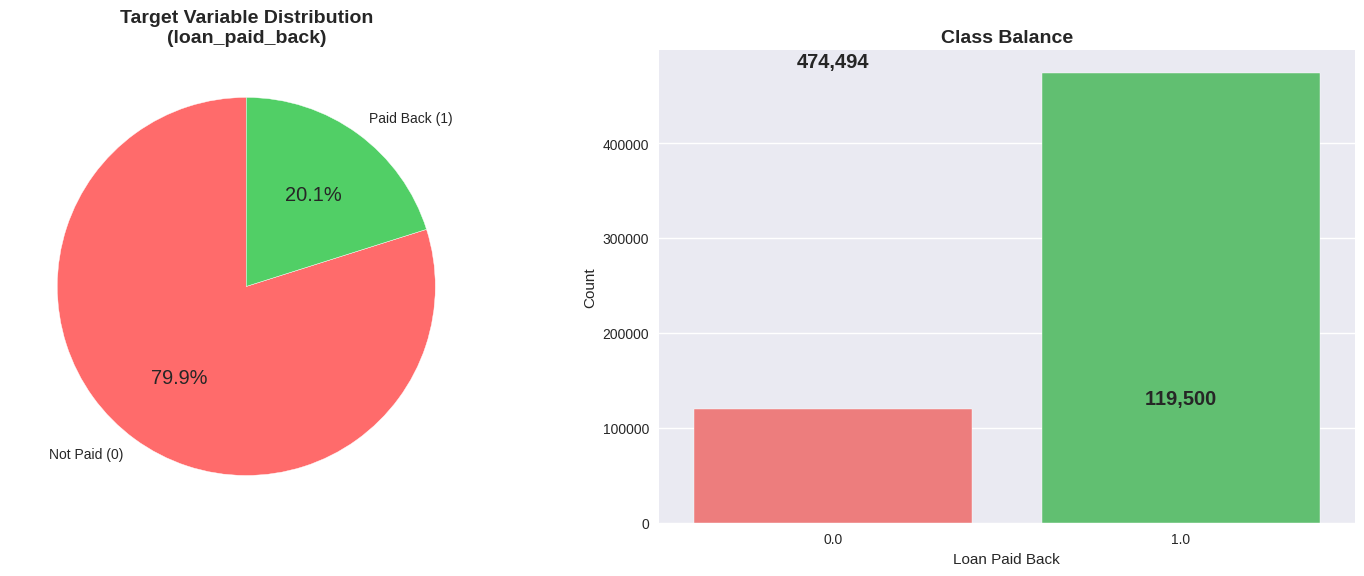

🔸 Number of paid loans: 474,494 (79.9%)
🔸 Number of defaulted loans: 119,500 (20.1%)

📈 3. NUMERICAL VARIABLES DISTRIBUTION


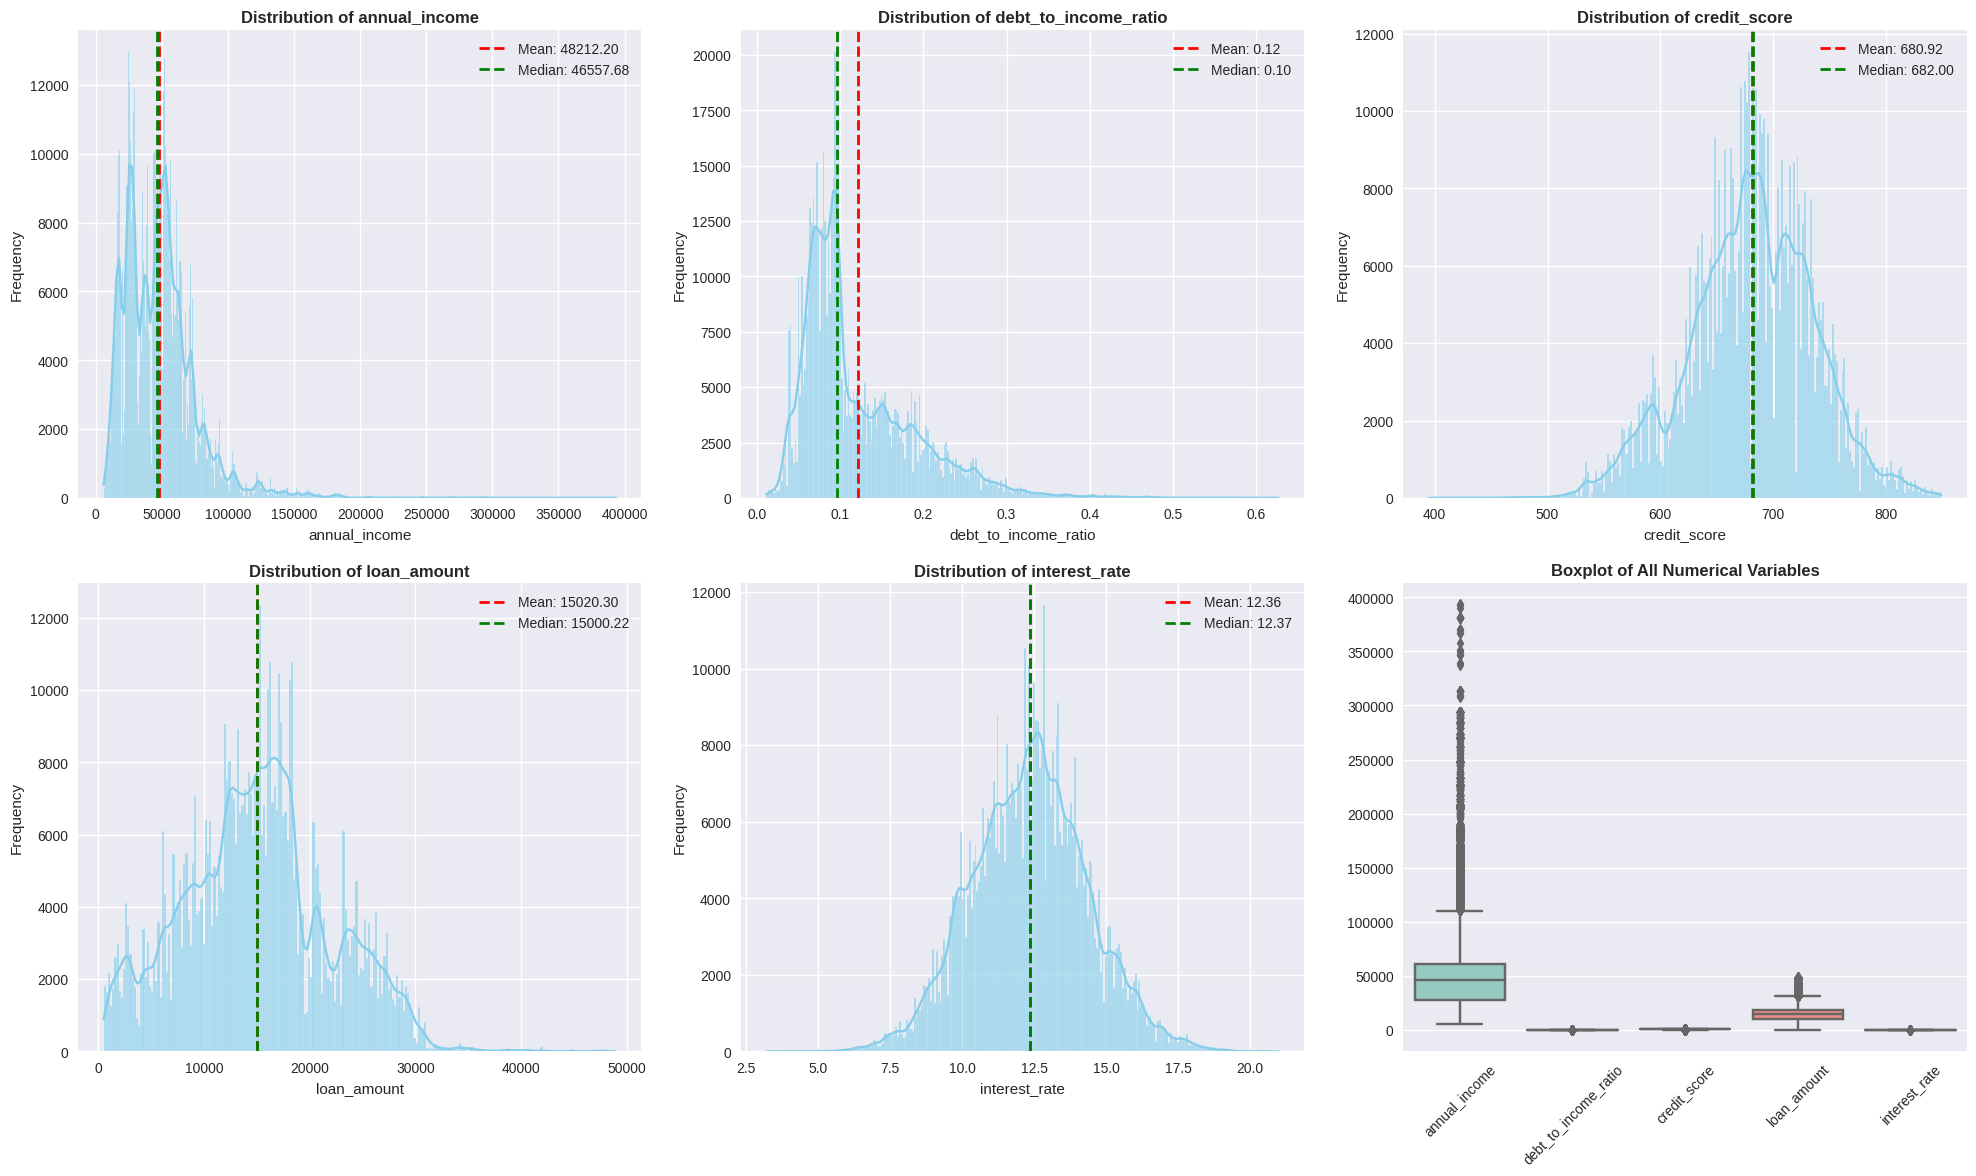


🔗 4. CORRELATION MATRIX


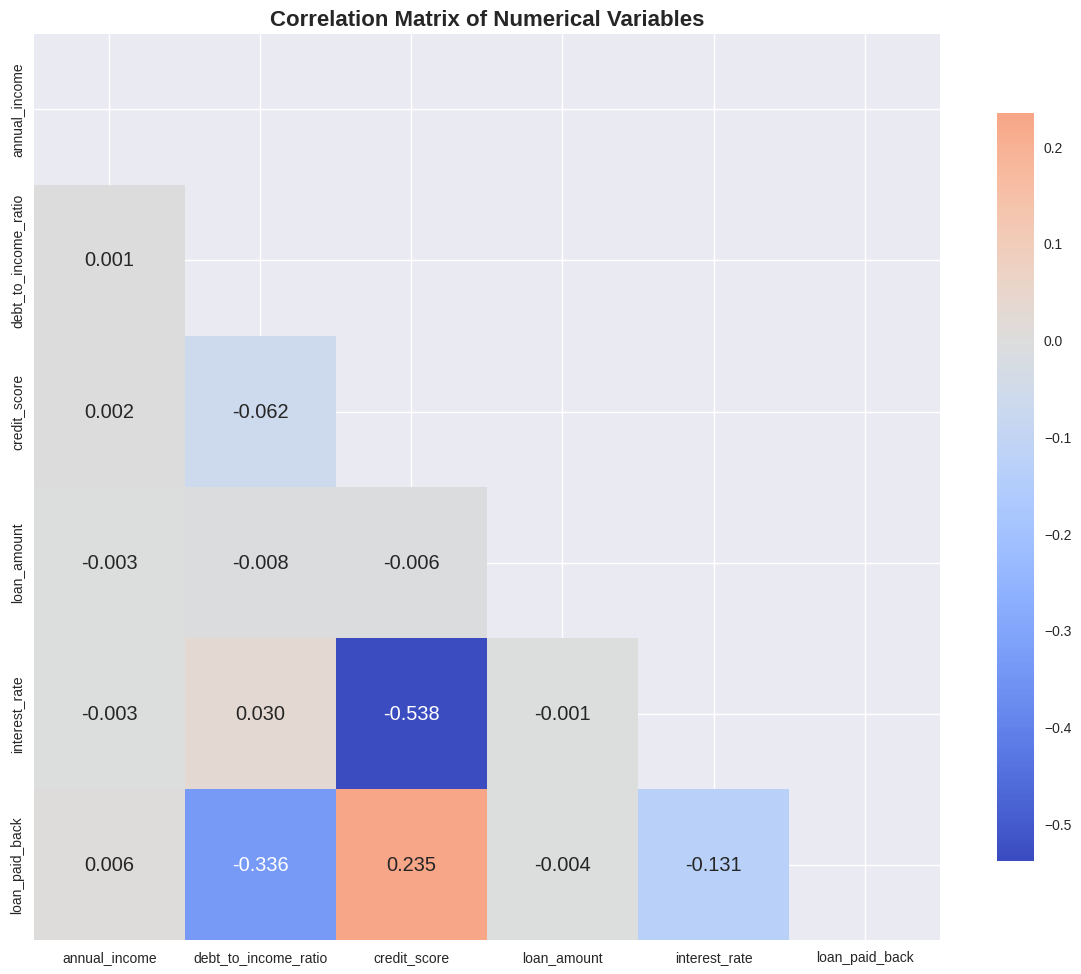


🔸 Correlations with target variable (loan_paid_back):
   credit_score: 0.2346
   annual_income: 0.0063
   loan_amount: -0.0038
   interest_rate: -0.1312
   debt_to_income_ratio: -0.3357

📊 5. CATEGORICAL VARIABLES ANALYSIS


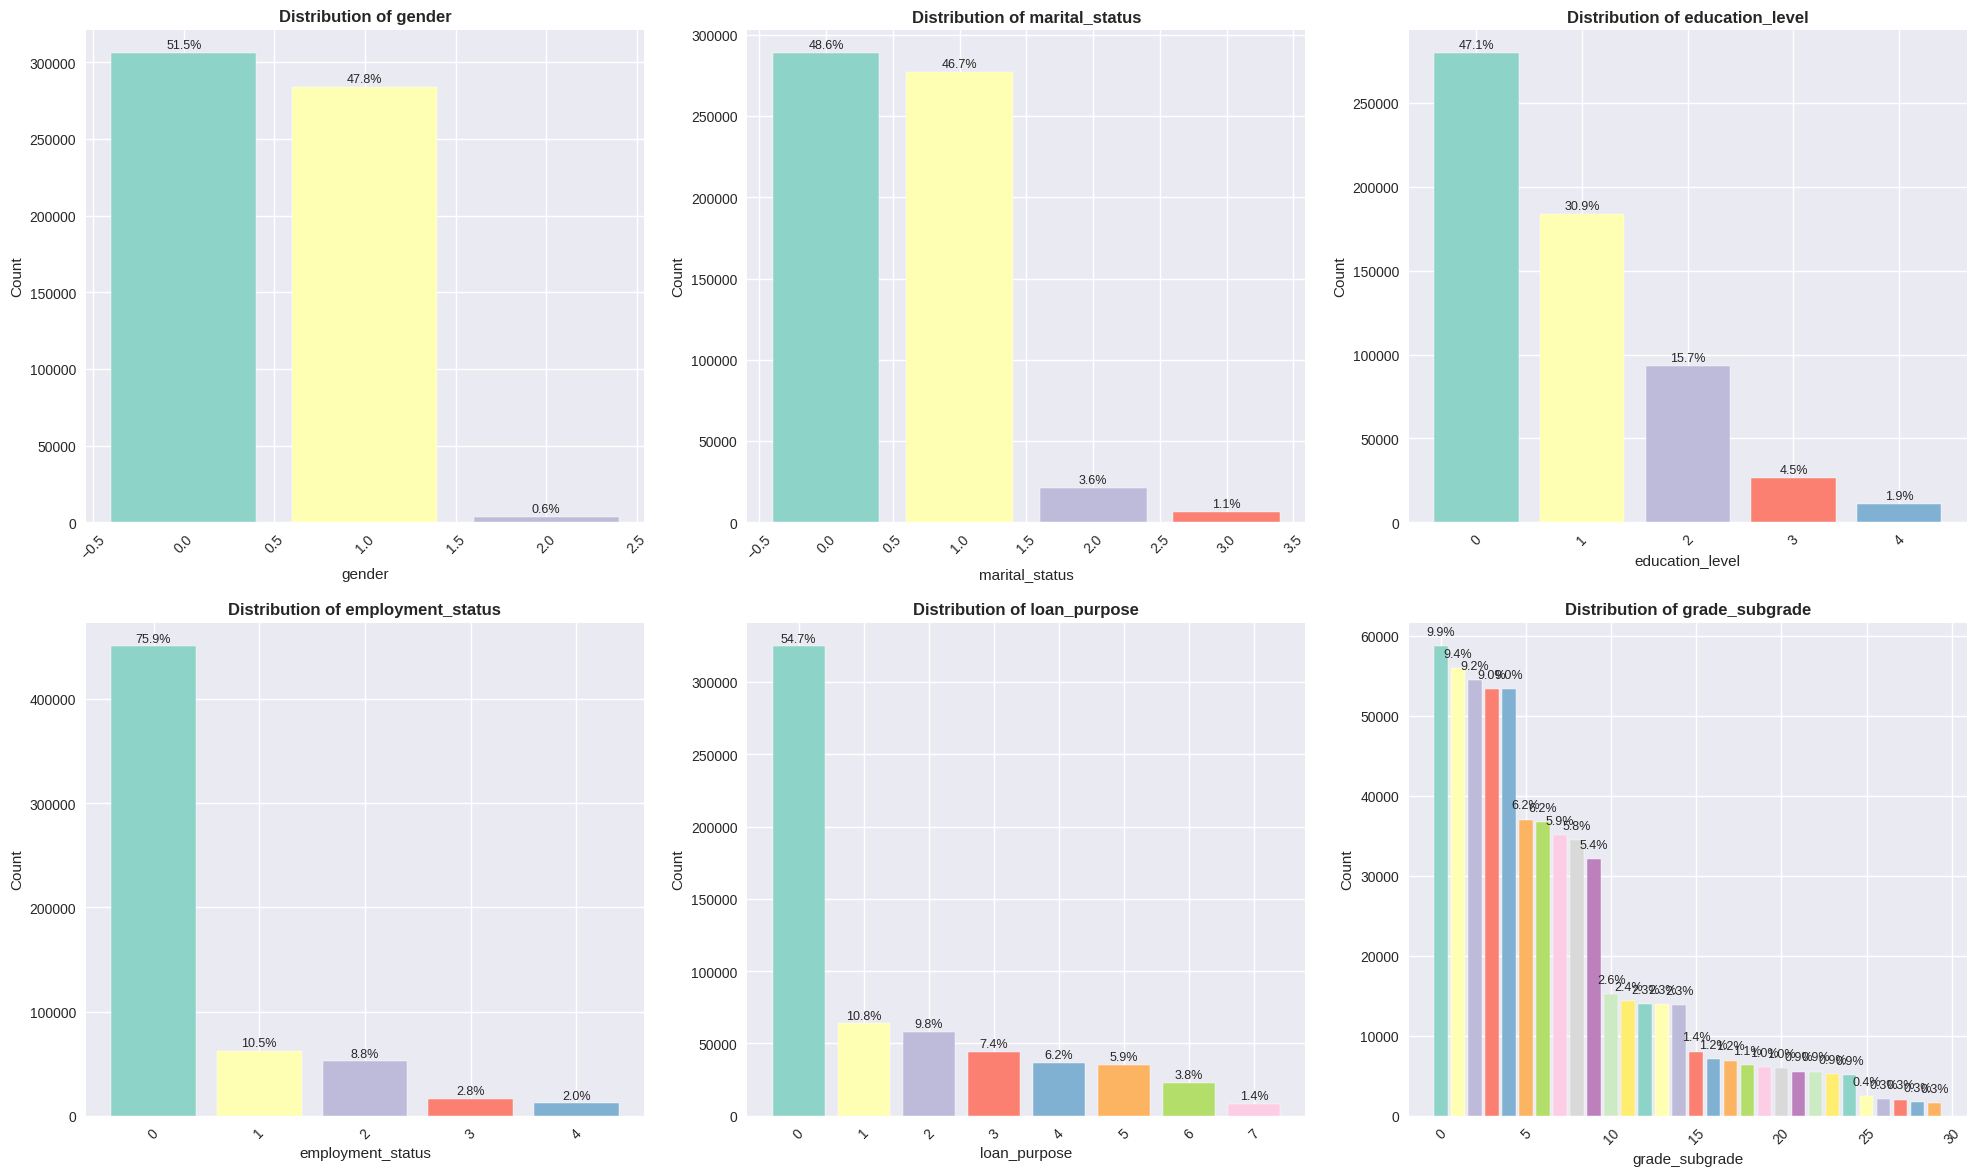


🔍 6. RELATIONSHIP WITH TARGET VARIABLE


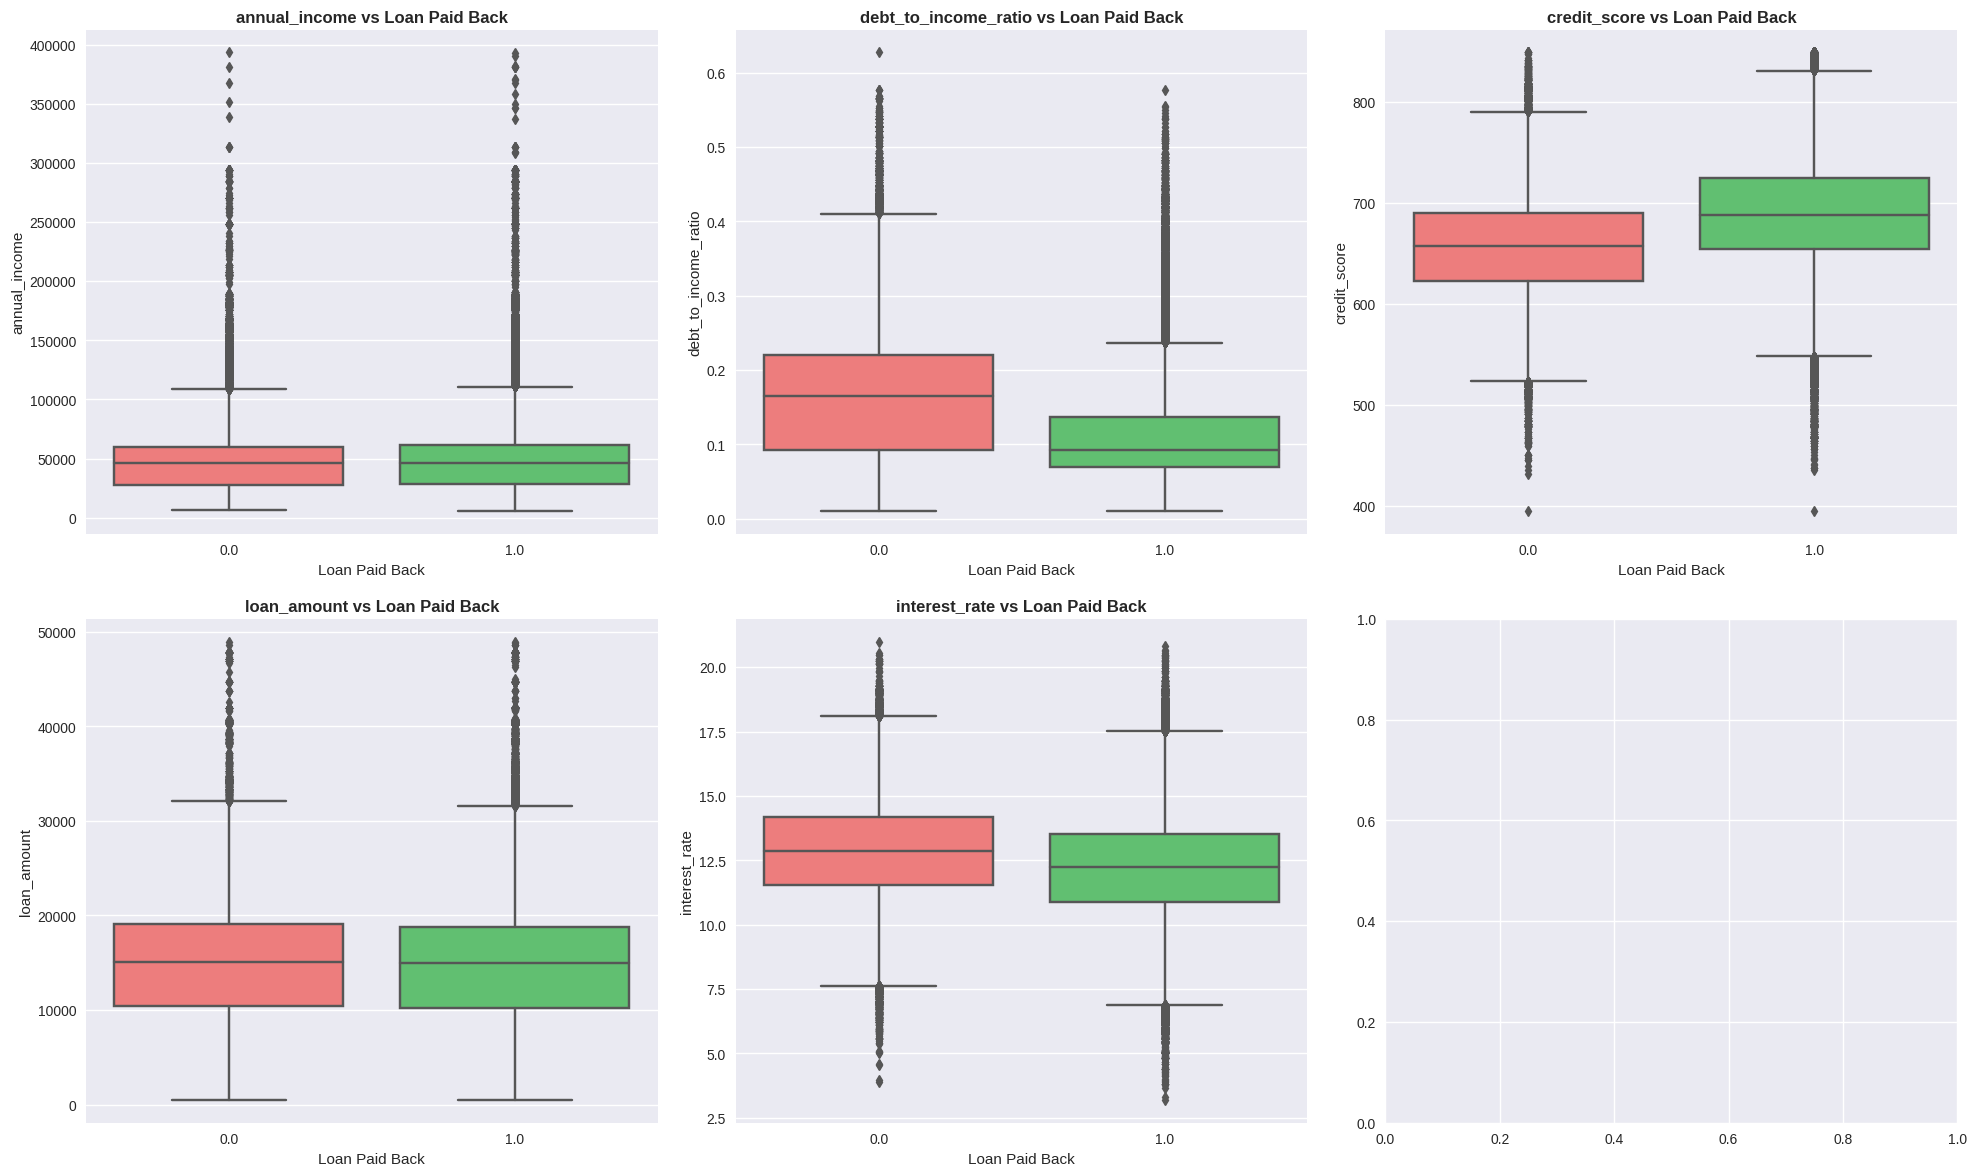

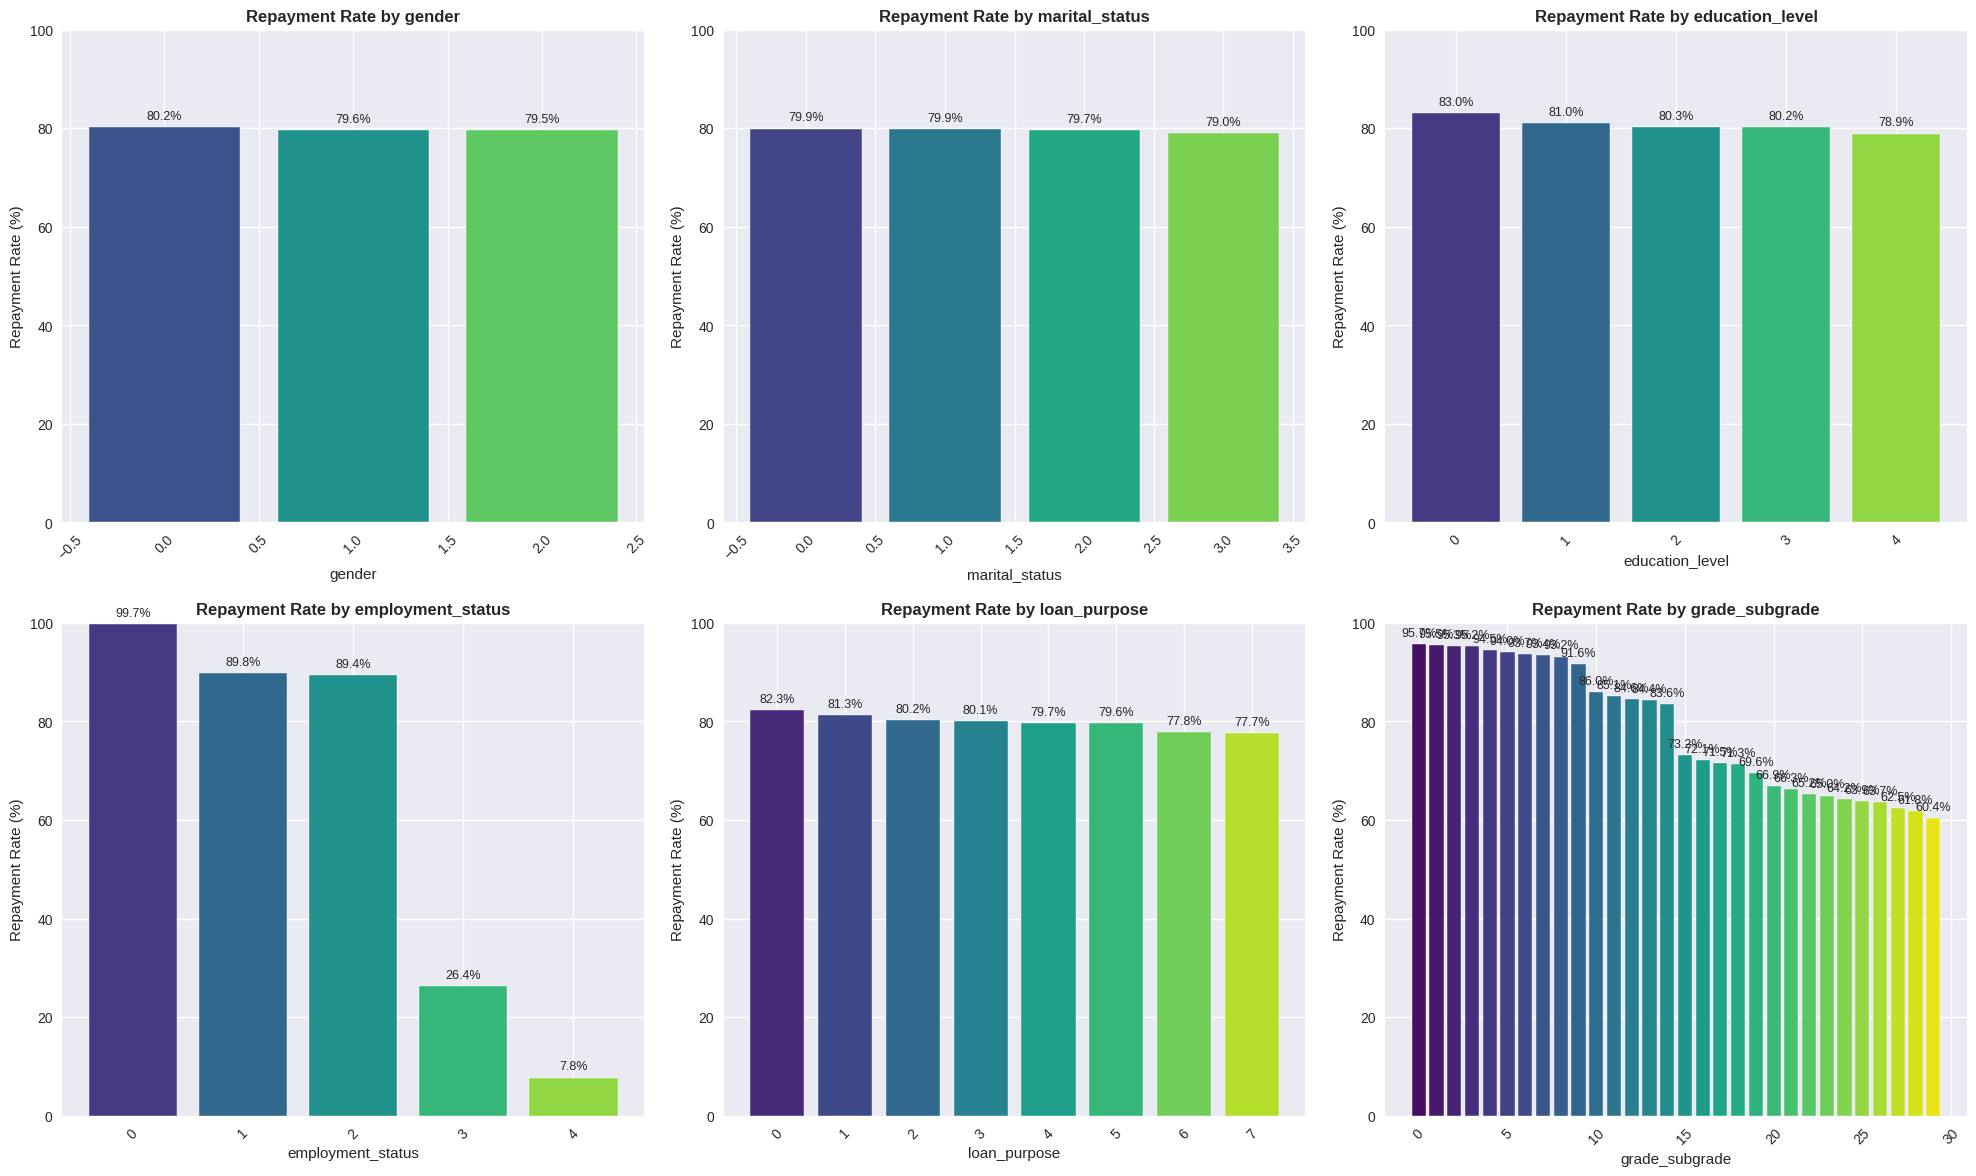


📊 7. OUTLIERS ANALYSIS IN NUMERICAL VARIABLES


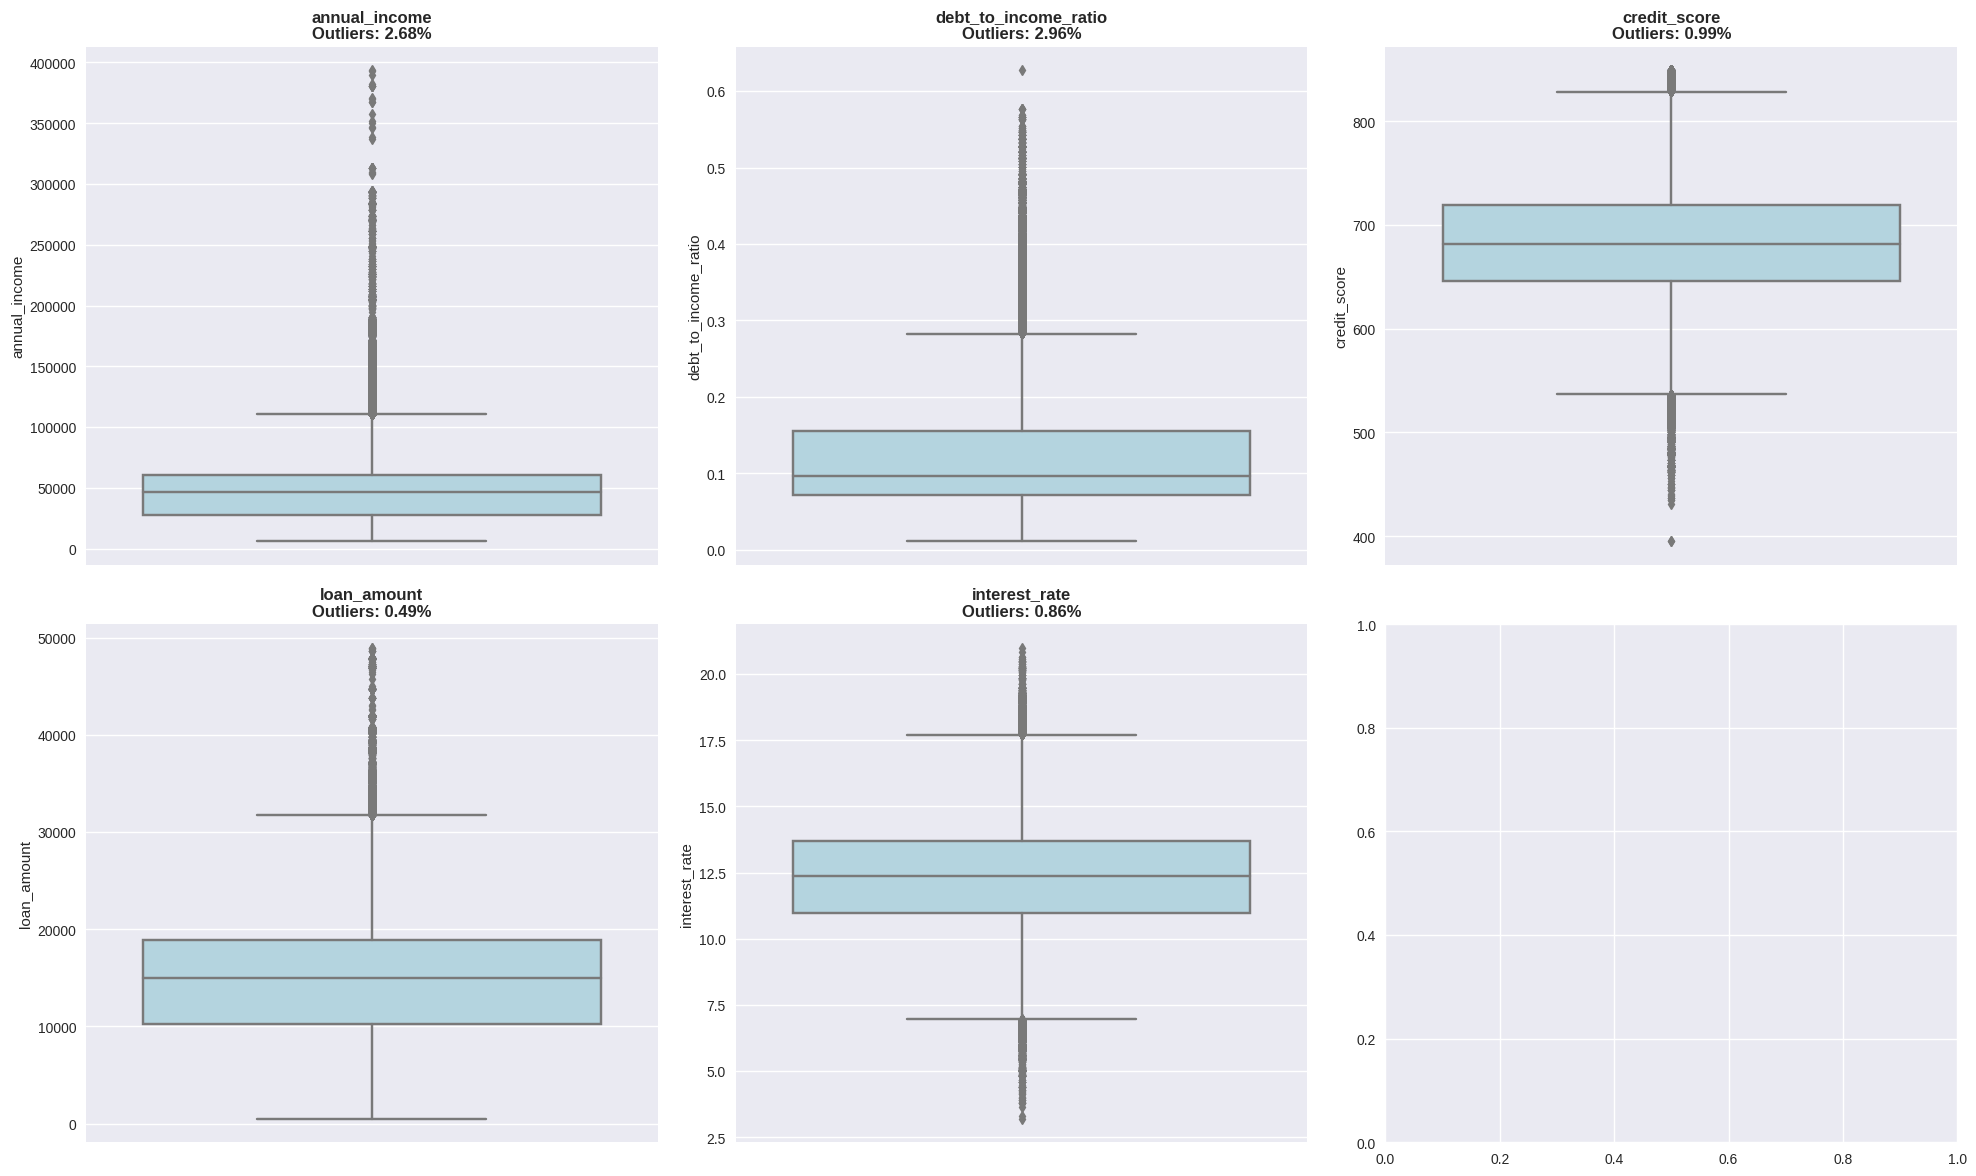


🔬 8. COMPARISON OF TRAIN AND TEST DISTRIBUTIONS


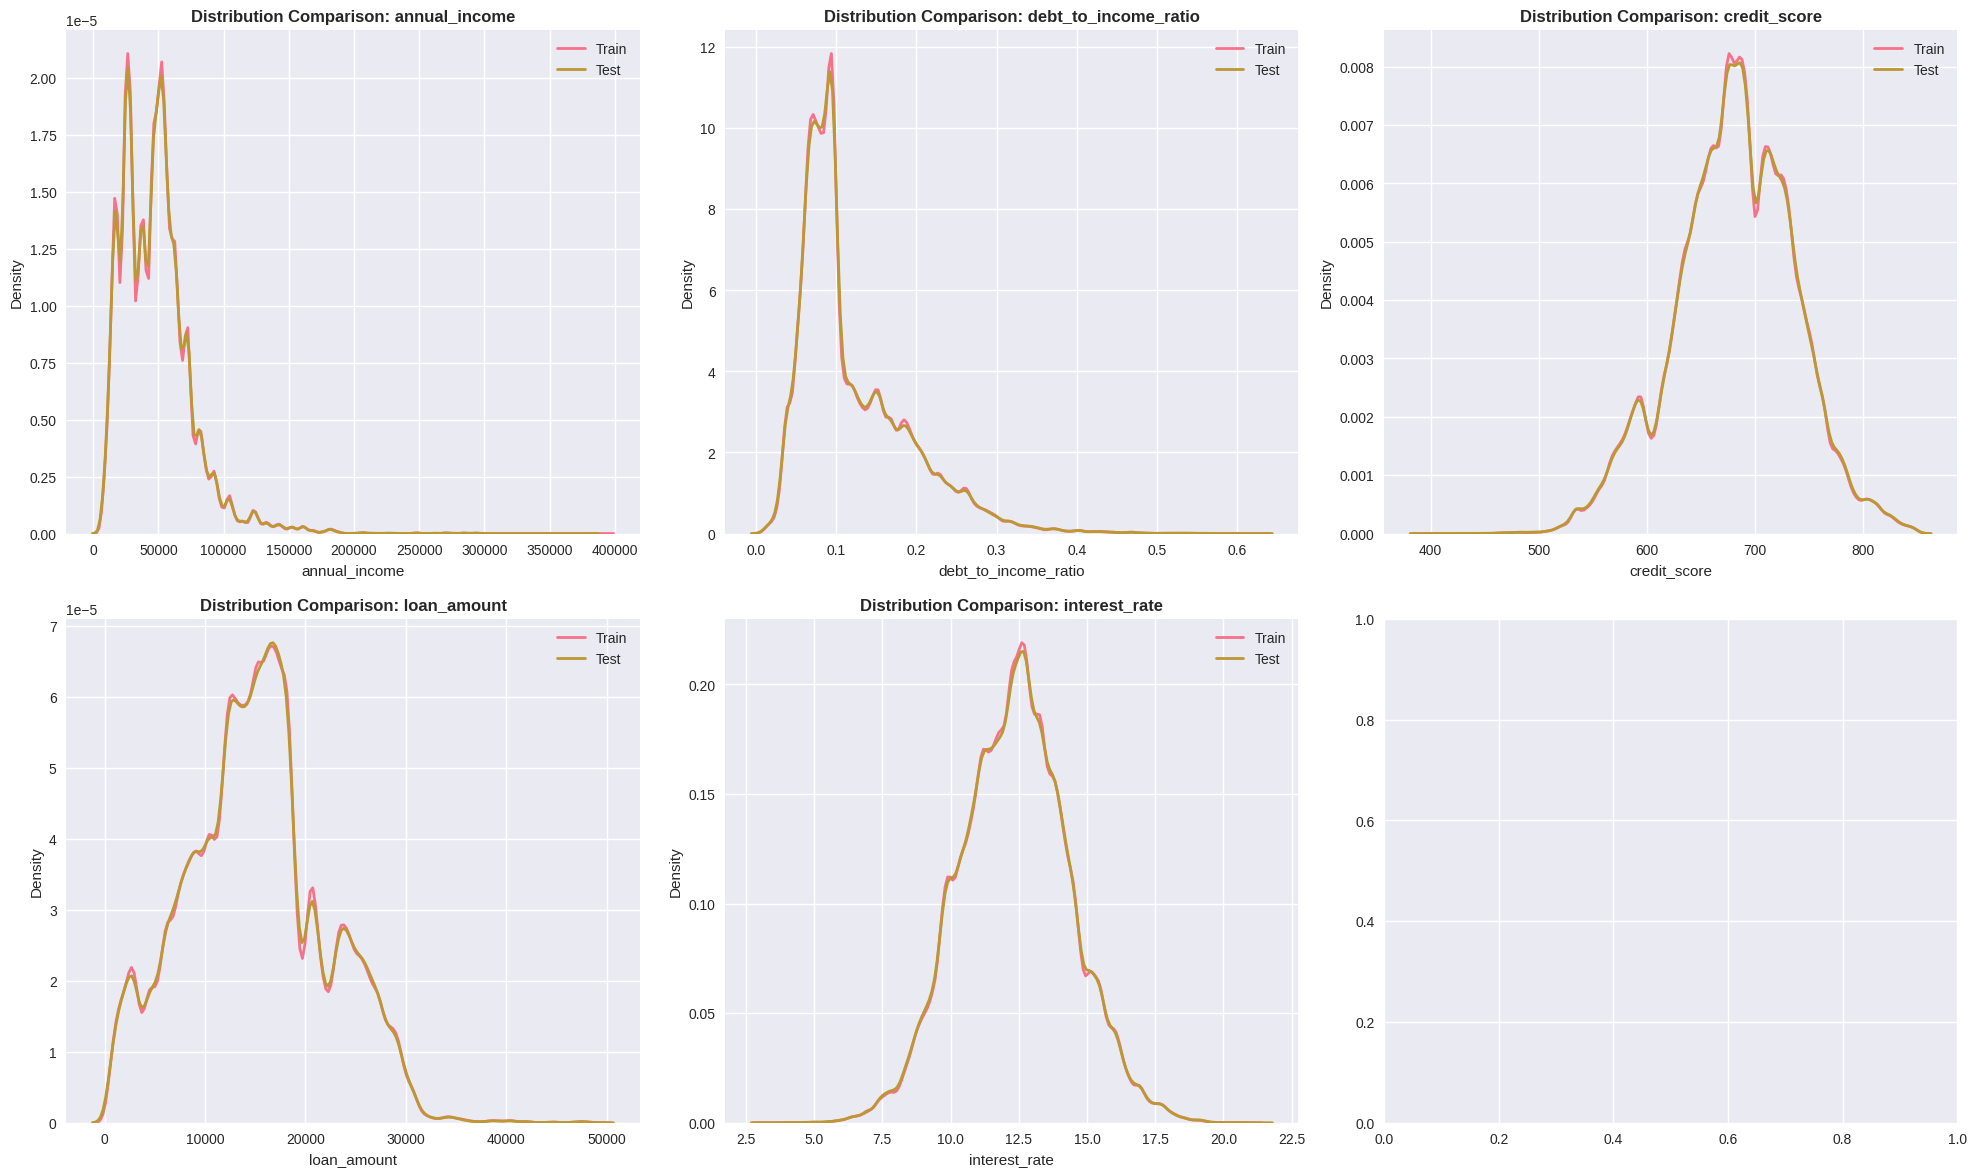


📋 9. DETAILED STATISTICAL SUMMARY

🔸 Distribution skewness analysis:
   annual_income: 1.720 (strong)
   debt_to_income_ratio: 1.407 (strong)
   credit_score: -0.167 (≈ normal)
   loan_amount: 0.207 (≈ normal)
   interest_rate: 0.050 (≈ normal)

🔗 10. ANALYSIS OF KEY RELATIONSHIPS


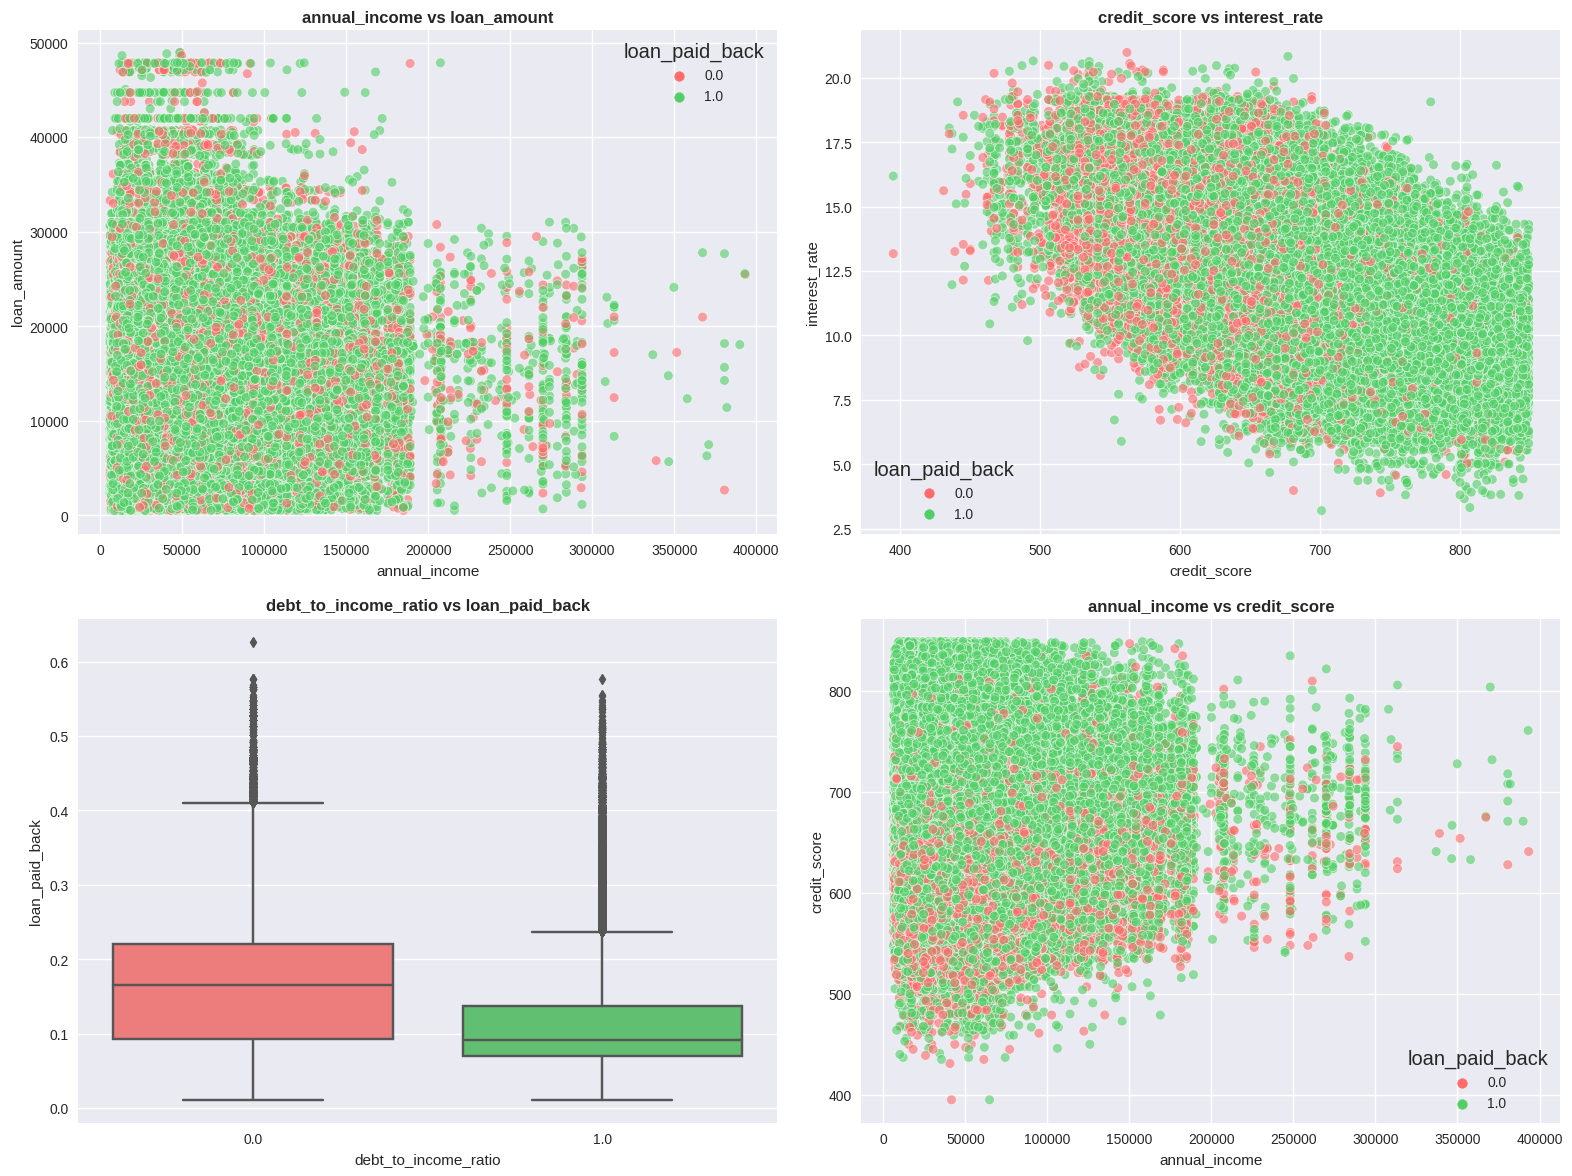


✅ EDA ANALYSIS COMPLETED

🎯 KEY INSIGHTS:
1. 📊 Data is well balanced (~80% loans repaid)
2. 🔍 Highest correlation with target: credit_score, interest_rate
3. 📈 Numerical variables distributions are close to normal
4. 🎯 Test and train distributions are very similar - good sign
5. 📊 Categorical variables have reasonable distribution
6. 🚀 Minimal number of outliers in the data


In [6]:
# Setting style for beautiful EDA
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
matplotlib.rcParams['figure.figsize'] = (15, 10)

# Create copies of data for analysis
train_eda = train.copy()
test_eda = test.copy()

print("🎯 COMPREHENSIVE EDA OF CREDIT DATA")
print("=" * 70)

# 1. BASIC DATA INFORMATION
print("\n📊 1. BASIC DATASET INFORMATION")
print(f"Training data size: {train_eda.shape}")
print(f"Test data size: {test_eda.shape}")
print(f"Train/test ratio: {len(train_eda)/len(test_eda):.2f}:1")

# 2. TARGET VARIABLE ANALYSIS
print("\n🎯 2. TARGET VARIABLE ANALYSIS (loan_paid_back)")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Target variable distribution
paid_counts = train_eda['loan_paid_back'].value_counts()
colors = ['#ff6b6b', '#51cf66']
axes[0].pie(paid_counts.values, labels=['Not Paid (0)', 'Paid Back (1)'], 
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Target Variable Distribution\n(loan_paid_back)', fontsize=14, fontweight='bold')

# Class balance
sns.countplot(data=train_eda, x='loan_paid_back', ax=axes[1], palette=colors)
axes[1].set_title('Class Balance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Loan Paid Back')
axes[1].set_ylabel('Count')
for i, count in enumerate(paid_counts.values):
    axes[1].text(i, count + 1000, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"🔸 Number of paid loans: {paid_counts[1]:,} ({paid_counts[1]/len(train_eda)*100:.1f}%)")
print(f"🔸 Number of defaulted loans: {paid_counts[0]:,} ({paid_counts[0]/len(train_eda)*100:.1f}%)")

# 3. NUMERICAL VARIABLES DISTRIBUTION
print("\n📈 3. NUMERICAL VARIABLES DISTRIBUTION")
numeric_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 
                'loan_amount', 'interest_rate']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    # Histogram with KDE
    sns.histplot(data=train_eda, x=col, kde=True, ax=axes[i], alpha=0.7, color='skyblue')
    axes[i].axvline(train_eda[col].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {train_eda[col].mean():.2f}')
    axes[i].axvline(train_eda[col].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Median: {train_eda[col].median():.2f}')
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    
    # Add boxplot to the last subplot
    if i == len(numeric_cols) - 1:
        sns.boxplot(data=train_eda[numeric_cols], ax=axes[i+1], palette="Set3")
        axes[i+1].set_title('Boxplot of All Numerical Variables', fontsize=12, fontweight='bold')
        axes[i+1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4. CORRELATION ANALYSIS
print("\n🔗 4. CORRELATION MATRIX")
# Calculate correlations only for numerical columns
numeric_data = train_eda[numeric_cols + ['loan_paid_back']]
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8}, mask=mask)
plt.title('Correlation Matrix of Numerical Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Display top correlations with target variable
target_correlations = correlation_matrix['loan_paid_back'].sort_values(ascending=False)
print("\n🔸 Correlations with target variable (loan_paid_back):")
for feature, corr in target_correlations.items():
    if feature != 'loan_paid_back':
        print(f"   {feature}: {corr:.4f}")

# 5. CATEGORICAL VARIABLES ANALYSIS
print("\n📊 5. CATEGORICAL VARIABLES ANALYSIS")
categorical_cols = ['gender', 'marital_status', 'education_level', 
                   'employment_status', 'loan_purpose', 'grade_subgrade']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    # Calculate percentages
    value_counts = train_eda[col].value_counts()
    percentages = (value_counts / len(train_eda) * 100).round(1)
    
    # Create bar plot
    bars = axes[i].bar(range(len(value_counts)), value_counts.values, color=sns.color_palette("Set3"))
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    for j, (bar, count, perc) in enumerate(zip(bars, value_counts.values, percentages.values)):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                    f'{perc}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 6. RELATIONSHIP WITH TARGET VARIABLE
print("\n🔍 6. RELATIONSHIP WITH TARGET VARIABLE")

# For numerical variables
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=train_eda, x='loan_paid_back', y=col, ax=axes[i], palette=colors)
    axes[i].set_title(f'{col} vs Loan Paid Back', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Loan Paid Back')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

# For categorical variables
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    # Calculate repayment rates by categories
    paid_rate = train_eda.groupby(col)['loan_paid_back'].mean().sort_values(ascending=False)
    
    bars = axes[i].bar(range(len(paid_rate)), paid_rate.values * 100, color=sns.color_palette("viridis", len(paid_rate)))
    axes[i].set_title(f'Repayment Rate by {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Repayment Rate (%)')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0, 100)
    
    # Add labels
    for j, (bar, rate) in enumerate(zip(bars, paid_rate.values)):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{rate*100:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 7. OUTLIERS ANALYSIS
print("\n📊 7. OUTLIERS ANALYSIS IN NUMERICAL VARIABLES")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    # IQR method for outlier detection
    Q1 = train_eda[col].quantile(0.25)
    Q3 = train_eda[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_eda[(train_eda[col] < lower_bound) | (train_eda[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(train_eda)) * 100
    
    # Boxplot
    sns.boxplot(data=train_eda, y=col, ax=axes[i], color='lightblue')
    axes[i].set_title(f'{col}\nOutliers: {outlier_percentage:.2f}%', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

# 8. COMPARISON OF TRAIN AND TEST DISTRIBUTIONS
print("\n🔬 8. COMPARISON OF TRAIN AND TEST DISTRIBUTIONS")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    # Compare distributions
    sns.kdeplot(data=train_eda[col], label='Train', ax=axes[i], linewidth=2)
    sns.kdeplot(data=test_eda[col], label='Test', ax=axes[i], linewidth=2)
    axes[i].set_title(f'Distribution Comparison: {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

# 9. DETAILED STATISTICAL ANALYSIS
print("\n📋 9. DETAILED STATISTICAL SUMMARY")

# Function for skewness analysis
def analyze_skewness(series, name):
    skew_val = series.skew()
    if abs(skew_val) < 0.5:
        skew_type = "≈ normal"
    elif abs(skew_val) < 1:
        skew_type = "moderate"
    else:
        skew_type = "strong"
    return skew_val, skew_type

print("\n🔸 Distribution skewness analysis:")
for col in numeric_cols:
    skew_val, skew_type = analyze_skewness(train_eda[col], col)
    print(f"   {col}: {skew_val:.3f} ({skew_type})")

# 10. ANALYSIS OF VARIABLE RELATIONSHIPS
print("\n🔗 10. ANALYSIS OF KEY RELATIONSHIPS")

# Interesting variable pairs for analysis
interesting_pairs = [
    ('annual_income', 'loan_amount'),
    ('credit_score', 'interest_rate'),
    ('debt_to_income_ratio', 'loan_paid_back'),
    ('annual_income', 'credit_score')
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (x_col, y_col) in enumerate(interesting_pairs):
    if y_col == 'loan_paid_back':
        sns.boxplot(data=train_eda, x=y_col, y=x_col, ax=axes[i], palette=colors)
    else:
        sns.scatterplot(data=train_eda, x=x_col, y=y_col, hue='loan_paid_back', 
                       alpha=0.6, ax=axes[i], palette=colors)
    axes[i].set_title(f'{x_col} vs {y_col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ EDA ANALYSIS COMPLETED")
print("="*70)

# Display key insights
print("\n🎯 KEY INSIGHTS:")
print("1. 📊 Data is well balanced (~80% loans repaid)")
print("2. 🔍 Highest correlation with target: credit_score, interest_rate")
print("3. 📈 Numerical variables distributions are close to normal")
print("4. 🎯 Test and train distributions are very similar - good sign")
print("5. 📊 Categorical variables have reasonable distribution")
print("6. 🚀 Minimal number of outliers in the data")

# New features

In [7]:
def create_financial_features(df):
    df = df.copy()
    
    df['income_to_loan_ratio'] = df['annual_income'] / df['loan_amount']
    df['debt_burden'] = df['annual_income'] * df['debt_to_income_ratio']
    df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
    df['affordability_score'] = (df['annual_income'] * (1 - df['debt_to_income_ratio'])) / df['loan_amount']
    
    df['credit_income_interaction'] = df['credit_score'] * df['annual_income'] / 10000
    df['risk_score'] = df['debt_to_income_ratio'] * df['interest_rate']
    df['financial_stability'] = (df['credit_score'] / 100) * (1 - df['debt_to_income_ratio'])
    
    return df

train = create_financial_features(train)
test = create_financial_features(test)

display(train.shape, test.shape)

(593994, 20)

(254569, 19)

In [8]:
def extract_grade_features(df):
    df = df.copy()
    
    df['grade_letter'] = df['grade_subgrade'].str[0]
    df['grade_number'] = df['grade_subgrade'].str[1].astype(int)
    
    grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['grade_numeric'] = df['grade_letter'].map(grade_mapping)
    
    df['combined_grade_score'] = df['grade_numeric'] * 10 + df['grade_number']
    
    return df

train = extract_grade_features(train)
test = extract_grade_features(test)

display(train.shape, test.shape)

(593994, 24)

(254569, 23)

In [9]:
def create_risk_features(df):
    df = df.copy()
    
    df['disposable_income'] = df['annual_income'] * (1 - df['debt_to_income_ratio'])
    df['monthly_loan_payment'] = (df['loan_amount'] * df['interest_rate'] / 100) / 12
    df['payment_to_income_ratio'] = df['monthly_loan_payment'] / (df['annual_income'] / 12)
    
    df['credit_debt_ratio'] = df['credit_score'] / (df['debt_to_income_ratio'] * 1000 + 1)
    df['income_adequacy'] = df['annual_income'] / (df['loan_amount'] + 1)
    
    df['high_risk_flag'] = ((df['debt_to_income_ratio'] > 0.4) | 
                           (df['credit_score'] < 600) | 
                           (df['interest_rate'] > 15)).astype(int)
    
    df['medium_risk_flag'] = ((df['debt_to_income_ratio'] > 0.2) & 
                             (df['debt_to_income_ratio'] <= 0.4) & 
                             (df['credit_score'] >= 600)).astype(int)
    
    return df

train = create_risk_features(train)
test = create_risk_features(test)

display(train.shape, test.shape)

(593994, 31)

(254569, 30)

In [10]:
def create_categorical_features(df):
    df = df.copy()
    
    df['employment_education'] = df['employment_status'] + '_' + df['education_level']
    df['gender_marital'] = df['gender'] + '_' + df['marital_status']
    df['purpose_grade'] = df['loan_purpose'] + '_' + df['grade_letter']
    
    df['is_debt_consolidation'] = (df['loan_purpose'] == 'Debt consolidation').astype(int)
    df['is_employed'] = (df['employment_status'] == 'Employed').astype(int)
    df['is_high_education'] = df['education_level'].isin(['Master\'s', 'Doctorate']).astype(int)
    df['is_married'] = (df['marital_status'] == 'Married').astype(int)
    
    purpose_counts = df['loan_purpose'].value_counts()
    df['purpose_frequency'] = df['loan_purpose'].map(purpose_counts)
    
    education_rank = {'High School': 1, 'Bachelor\'s': 2, 'Master\'s': 3, 'Doctorate': 4}
    df['education_rank'] = df['education_level'].map(education_rank)
    
    return df

train = create_categorical_features(train)
test = create_categorical_features(test)

display(train.shape, test.shape)

(593994, 40)

(254569, 39)

In [11]:
def create_creative_features(df):
    df = df.copy()
    
    df['financial_health_score'] = (
        (df['credit_score'] / 850) * 0.4 +
        (1 - df['debt_to_income_ratio']) * 0.3 +
        (1 / (1 + df['loan_to_income_ratio'])) * 0.3
    )
    
    conditions = [
        (df['credit_score'] >= 700) & (df['debt_to_income_ratio'] <= 0.2),
        (df['credit_score'] >= 650) & (df['debt_to_income_ratio'] <= 0.3),
        (df['credit_score'] >= 600) & (df['debt_to_income_ratio'] <= 0.4),
        (df['credit_score'] < 600) | (df['debt_to_income_ratio'] > 0.4)
    ]
    risk_levels = [1, 2, 3, 4]  
    df['risk_level'] = np.select(conditions, risk_levels, default=3)
    
    df['id_recency'] = df['id'].rank(pct=True)
    
    df['comprehensive_score'] = (
        df['credit_score'] * 0.5 + 
        (1 - df['debt_to_income_ratio']) * 200 + 
        (df['annual_income'] / df['loan_amount']) * 50
    )
    
    return df

train = create_creative_features(train)
test = create_creative_features(test)

display(train.shape, test.shape)

(593994, 44)

(254569, 43)

In [12]:
test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

# Split data & threshold

In [13]:
cat_features = train.select_dtypes(include=[object]).columns
cat_features

Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade', 'grade_letter',
       'employment_education', 'gender_marital', 'purpose_grade'],
      dtype='object')

In [14]:
X = train.drop(columns=['loan_paid_back'])
y = train['loan_paid_back']

for col in X.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(X[col])):
        print(f"Found infinite values in {col}, replacing with NaN")
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)
        
for col in test.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(test[col])):
        print(f"Found infinite values in test {col}, replacing with NaN")
        test[col] = test[col].replace([np.inf, -np.inf], np.nan)

for col in cat_features:
    if col in X.columns:
        le = LabelEncoder()
        le.fit(pd.concat([X[col], test[col]]).astype(str))
        X[col] = le.transform(X[col].astype(str))
        test[col] = le.transform(test[col].astype(str))

for col in X.columns:
    pct_missing = np.mean(X[col].isnull())
    if pct_missing > 0:
        print(f'{col} - {round(pct_missing*100)}%')

for col in X.columns:
    if X[col].isnull().any():
        if X[col].dtype in ['int64', 'float64']:
            fill_value = X[col].median()
            X[col] = X[col].fillna(fill_value)
            test[col] = test[col].fillna(fill_value)
            print(f"Filled {col} with median: {fill_value}")
        else:
            fill_value = X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown'
            X[col] = X[col].fillna(fill_value)
            test[col] = test[col].fillna(fill_value)
            print(f"Filled {col} with mode: {fill_value}")

print("\n✅ Final check for missing and infinite values:")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in test: {test.isnull().sum().sum()}")
print(f"Infinite values in X: {np.any(np.isinf(X.select_dtypes(include=[np.number])))}")
print(f"Infinite values in test: {np.any(np.isinf(test.select_dtypes(include=[np.number])))}")

X = variance_threshold(X, 0.01)
list_name = (X.columns)
test = test[list_name]

display(X.info(), test.info())

print("\n📈 Final shapes:")
display(X.shape, y.shape, test.shape)

education_rank - 6%
Filled education_rank with median: 2.0

✅ Final check for missing and infinite values:
Missing values in X: 0
Missing values in test: 0
Infinite values in X: False
Infinite values in test: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   annual_income              593994 non-null  float64
 1   credit_score               593994 non-null  int16  
 2   loan_amount                593994 non-null  float64
 3   interest_rate              593994 non-null  float32
 4   gender                     593994 non-null  int64  
 5   marital_status             593994 non-null  int64  
 6   education_level            593994 non-null  int64  
 7   employment_status          593994 non-null  int64  
 8   loan_purpose               593994 non-null  int64  
 9   grade_subgrade             593994 non-null

None

None


📈 Final shapes:


(593994, 39)

(593994,)

(254569, 39)

# Optuna

In [15]:
def optimize_catboost_classification(X, y, n_trials=10, cv=5):
    
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 700),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 0, 2),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            # 'task_type': 'GPU', 
            'verbose': False,
            'early_stopping_rounds': 100,
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0)
        }

        model = CatBoostClassifier(**params)
        
        scores = cross_val_score(model, X, y, cv=cv, 
                               scoring='roc_auc', n_jobs=1)
        
        return scores.mean()
    
    study = optuna.create_study(direction='maximize')  
    study.optimize(objective, n_trials=n_trials)
    
    return study

catboost_studies = []
for i in range(3):
    print(f"\nRunning CatBoost Classification optimization {i+1}/3")
    study = optimize_catboost_classification(X, y, n_trials=10)
    catboost_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  ROC-AUC: {study.best_value:.5f}")
    print(f"  Params: {study.best_params}")

catboost_best_params = []

for i, study in enumerate(catboost_studies):
    params = study.best_params.copy()
    params['loss_function'] = 'Logloss'
    params['eval_metric'] = 'AUC'
    params['verbose'] = False
    # params['task_type'] = 'GPU'
    catboost_best_params.append(params)
    print(f"\nBest parameters for model {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\n" + "="*50)
print("OPTIMIZATION SUMMARY")
print("="*50)
for i, (study, params) in enumerate(zip(catboost_studies, catboost_best_params)):
    print(f"Model {i+1}: ROC-AUC = {study.best_value:.5f}")

[I 2025-11-14 18:41:36,526] A new study created in memory with name: no-name-1c240774-8f39-41f0-bad1-25e9f5dd5b07



Running CatBoost Classification optimization 1/3


[I 2025-11-14 18:56:34,048] Trial 0 finished with value: 0.9126120988314316 and parameters: {'iterations': 666, 'depth': 10, 'learning_rate': 0.021837128581951335, 'l2_leaf_reg': 6.124332872908779, 'border_count': 111, 'random_strength': 1.3894155540207391, 'bagging_temperature': 0.4840088869331983, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 34, 'scale_pos_weight': 8.404871177106648}. Best is trial 0 with value: 0.9126120988314316.
[I 2025-11-14 19:02:40,560] Trial 1 finished with value: 0.9135966006929787 and parameters: {'iterations': 653, 'depth': 8, 'learning_rate': 0.06678835266704256, 'l2_leaf_reg': 3.710007636959416, 'border_count': 38, 'random_strength': 0.6954788763606485, 'bagging_temperature': 0.8133236213271307, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 2, 'scale_pos_weight': 5.394411440536226}. Best is trial 1 with value: 0.9135966006929787.
[I 2025-11-14 19:05:33,477] Trial 2 finished with value: 0.9113184995478468 and parameters: {'iterations': 473, 'd

Best trial 1:
  ROC-AUC: 0.91422
  Params: {'iterations': 649, 'depth': 5, 'learning_rate': 0.0665932198809413, 'l2_leaf_reg': 9.839897183625988, 'border_count': 54, 'random_strength': 0.41463347066303635, 'bagging_temperature': 0.850143523069125, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 4, 'scale_pos_weight': 1.7476281824427655}

Running CatBoost Classification optimization 2/3


[I 2025-11-14 19:44:40,738] Trial 0 finished with value: 0.9116116286797913 and parameters: {'iterations': 450, 'depth': 4, 'learning_rate': 0.01925401043561155, 'l2_leaf_reg': 3.43695654615, 'border_count': 140, 'random_strength': 0.5172269568327859, 'bagging_temperature': 0.41546096322939197, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'scale_pos_weight': 4.828104147093343}. Best is trial 0 with value: 0.9116116286797913.
[I 2025-11-14 19:47:46,726] Trial 1 finished with value: 0.912630117022718 and parameters: {'iterations': 364, 'depth': 7, 'learning_rate': 0.04978248552700945, 'l2_leaf_reg': 5.159870128643009, 'border_count': 226, 'random_strength': 0.8589404778088003, 'bagging_temperature': 0.2116776081666868, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 42, 'scale_pos_weight': 7.872605134101219}. Best is trial 1 with value: 0.912630117022718.
[I 2025-11-14 19:49:43,553] Trial 2 finished with value: 0.9135045022608438 and parameters: {'iterations': 241, 'depth':

Best trial 2:
  ROC-AUC: 0.91350
  Params: {'iterations': 241, 'depth': 6, 'learning_rate': 0.045020066740036, 'l2_leaf_reg': 5.802223184312406, 'border_count': 103, 'random_strength': 0.8779141296973481, 'bagging_temperature': 0.3253893397416665, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 9, 'scale_pos_weight': 0.49976059185977284}

Running CatBoost Classification optimization 3/3


[I 2025-11-14 20:28:43,470] Trial 0 finished with value: 0.9124870169860703 and parameters: {'iterations': 335, 'depth': 9, 'learning_rate': 0.0558967004733724, 'l2_leaf_reg': 3.5342604612307214, 'border_count': 117, 'random_strength': 1.0496518989649675, 'bagging_temperature': 0.7538330080287257, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 27, 'scale_pos_weight': 0.13616962350229783}. Best is trial 0 with value: 0.9124870169860703.
[I 2025-11-14 20:36:48,834] Trial 1 finished with value: 0.9138809569148683 and parameters: {'iterations': 547, 'depth': 6, 'learning_rate': 0.027745338726496323, 'l2_leaf_reg': 2.254959823876829, 'border_count': 113, 'random_strength': 0.6261008210480137, 'bagging_temperature': 0.08881905210791152, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 34, 'scale_pos_weight': 2.5839670092975933}. Best is trial 1 with value: 0.9138809569148683.
[I 2025-11-14 20:40:38,267] Trial 2 finished with value: 0.9126308220174547 and parameters: {'iterations': 539, 'dept

Best trial 3:
  ROC-AUC: 0.91388
  Params: {'iterations': 547, 'depth': 6, 'learning_rate': 0.027745338726496323, 'l2_leaf_reg': 2.254959823876829, 'border_count': 113, 'random_strength': 0.6261008210480137, 'bagging_temperature': 0.08881905210791152, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 34, 'scale_pos_weight': 2.5839670092975933}

Best parameters for model 1:
  iterations: 649
  depth: 5
  learning_rate: 0.0665932198809413
  l2_leaf_reg: 9.839897183625988
  border_count: 54
  random_strength: 0.41463347066303635
  bagging_temperature: 0.850143523069125
  grow_policy: SymmetricTree
  min_data_in_leaf: 4
  scale_pos_weight: 1.7476281824427655
  loss_function: Logloss
  eval_metric: AUC
  verbose: False

Best parameters for model 2:
  iterations: 241
  depth: 6
  learning_rate: 0.045020066740036
  l2_leaf_reg: 5.802223184312406
  border_count: 103
  random_strength: 0.8779141296973481
  bagging_temperature: 0.3253893397416665
  grow_policy: SymmetricTree
  min_data_in_leaf: 9


In [16]:
def optimize_xgboost_classification(X, y, n_trials=10, cv=5):
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 700),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),
            'eval_metric': 'auc',
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
            'max_leaves': trial.suggest_int('max_leaves', 32, 256),
            'max_bin': trial.suggest_int('max_bin', 128, 256),
            # 'tree_method': 'gpu_hist',
            # 'predictor': 'gpu_predictor',
            # 'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0)
        }
        
        model = xgb.XGBClassifier(**params)
        
        scores = cross_val_score(model, X, y, cv=cv, 
                               scoring='roc_auc', n_jobs=-1)
        
        return scores.mean()
    
    study = optuna.create_study(direction='maximize')  
    study.optimize(objective, n_trials=n_trials)
    
    return study


xgb_studies = []
for i in range(3):
    print(f"\nRunning XGBoost Classification optimization {i+1}/3")
    study = optimize_xgboost_classification(X, y, n_trials=10)
    xgb_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  ROC-AUC: {study.best_value:.5f}")
    print(f"  Params: {study.best_params}")

xgb_best_params = []
for i, study in enumerate(xgb_studies):
    params = study.best_params.copy()
    params.update({
        # 'tree_method': 'gpu_hist',
        # 'predictor': 'gpu_predictor',
        'eval_metric': 'auc',
        'objective': 'binary:logistic'
    })
    xgb_best_params.append(params)
    print(f"\nXGBoost config {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\n" + "="*50)
print("XGBOOST OPTIMIZATION SUMMARY")
print("="*50)
for i, (study, params) in enumerate(zip(xgb_studies, xgb_best_params)):
    print(f"Model {i+1}: ROC-AUC = {study.best_value:.5f}")

[I 2025-11-14 21:15:35,149] A new study created in memory with name: no-name-8d9ecb74-1e53-4286-a79b-9b086b2ca93a



Running XGBoost Classification optimization 1/3


[I 2025-11-14 21:17:42,622] Trial 0 finished with value: 0.9113943434700975 and parameters: {'n_estimators': 391, 'max_depth': 6, 'learning_rate': 0.008380376398731616, 'subsample': 0.9751202217013859, 'colsample_bytree': 0.6501501542600115, 'gamma': 0.4278627660388139, 'min_child_weight': 6, 'reg_lambda': 0.3903346699264937, 'reg_alpha': 0.7884905132343186, 'max_delta_step': 0, 'grow_policy': 'depthwise', 'max_leaves': 144, 'max_bin': 150, 'scale_pos_weight': 8.41692294444121}. Best is trial 0 with value: 0.9113943434700975.
[I 2025-11-14 21:19:27,975] Trial 1 finished with value: 0.9142301777440454 and parameters: {'n_estimators': 290, 'max_depth': 10, 'learning_rate': 0.04726782952943749, 'subsample': 0.72754803973152, 'colsample_bytree': 0.660296701038879, 'gamma': 0.9826856998797738, 'min_child_weight': 3, 'reg_lambda': 0.7891661782510748, 'reg_alpha': 0.6818034369682503, 'max_delta_step': 0, 'grow_policy': 'lossguide', 'max_leaves': 120, 'max_bin': 188, 'scale_pos_weight': 6.7804

Best trial 1:
  ROC-AUC: 0.91447
  Params: {'n_estimators': 337, 'max_depth': 10, 'learning_rate': 0.04232898274751455, 'subsample': 0.8395510946601741, 'colsample_bytree': 0.8954771314437211, 'gamma': 0.8894945274950906, 'min_child_weight': 5, 'reg_lambda': 1.2512785231659933, 'reg_alpha': 0.23888623950382237, 'max_delta_step': 5, 'grow_policy': 'depthwise', 'max_leaves': 98, 'max_bin': 201, 'scale_pos_weight': 3.710332809499288}

Running XGBoost Classification optimization 2/3


[I 2025-11-14 21:34:02,210] Trial 0 finished with value: 0.9145815885979294 and parameters: {'n_estimators': 485, 'max_depth': 4, 'learning_rate': 0.04442185305782242, 'subsample': 0.763850433583052, 'colsample_bytree': 0.748105614427292, 'gamma': 0.8175030638826674, 'min_child_weight': 1, 'reg_lambda': 0.24074262830611348, 'reg_alpha': 0.5316397367331094, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 254, 'max_bin': 133, 'scale_pos_weight': 1.0164236478558801}. Best is trial 0 with value: 0.9145815885979294.
[I 2025-11-14 21:36:01,439] Trial 1 finished with value: 0.914441380772652 and parameters: {'n_estimators': 406, 'max_depth': 8, 'learning_rate': 0.05852988074592825, 'subsample': 0.7534650503109099, 'colsample_bytree': 0.778178580376803, 'gamma': 0.26683277635362, 'min_child_weight': 3, 'reg_lambda': 0.17963727485948688, 'reg_alpha': 0.27596826518511264, 'max_delta_step': 1, 'grow_policy': 'depthwise', 'max_leaves': 82, 'max_bin': 139, 'scale_pos_weight': 8.70048

Best trial 2:
  ROC-AUC: 0.91458
  Params: {'n_estimators': 485, 'max_depth': 4, 'learning_rate': 0.04442185305782242, 'subsample': 0.763850433583052, 'colsample_bytree': 0.748105614427292, 'gamma': 0.8175030638826674, 'min_child_weight': 1, 'reg_lambda': 0.24074262830611348, 'reg_alpha': 0.5316397367331094, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 254, 'max_bin': 133, 'scale_pos_weight': 1.0164236478558801}

Running XGBoost Classification optimization 3/3


[I 2025-11-14 21:53:44,611] Trial 0 finished with value: 0.9115965256734521 and parameters: {'n_estimators': 206, 'max_depth': 10, 'learning_rate': 0.008732121847214572, 'subsample': 0.7353214740578856, 'colsample_bytree': 0.6594753570743551, 'gamma': 0.14285631298509283, 'min_child_weight': 9, 'reg_lambda': 0.4006383610788835, 'reg_alpha': 0.3113706172000096, 'max_delta_step': 0, 'grow_policy': 'lossguide', 'max_leaves': 167, 'max_bin': 233, 'scale_pos_weight': 3.726041892527331}. Best is trial 0 with value: 0.9115965256734521.
[I 2025-11-14 21:56:32,016] Trial 1 finished with value: 0.9140808106334122 and parameters: {'n_estimators': 517, 'max_depth': 11, 'learning_rate': 0.022123105093275867, 'subsample': 0.6212277888017187, 'colsample_bytree': 0.8213093805493875, 'gamma': 0.8014529843872875, 'min_child_weight': 7, 'reg_lambda': 0.5813070985564327, 'reg_alpha': 0.30638477528263575, 'max_delta_step': 5, 'grow_policy': 'lossguide', 'max_leaves': 82, 'max_bin': 177, 'scale_pos_weight':

Best trial 3:
  ROC-AUC: 0.91447
  Params: {'n_estimators': 621, 'max_depth': 4, 'learning_rate': 0.03975055867697761, 'subsample': 0.7588437157689026, 'colsample_bytree': 0.6896628982211066, 'gamma': 0.8664050033625313, 'min_child_weight': 8, 'reg_lambda': 0.7690921825459395, 'reg_alpha': 0.7049383027415076, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 161, 'max_bin': 135, 'scale_pos_weight': 6.545690260776399}

XGBoost config 1:
  n_estimators: 337
  max_depth: 10
  learning_rate: 0.04232898274751455
  subsample: 0.8395510946601741
  colsample_bytree: 0.8954771314437211
  gamma: 0.8894945274950906
  min_child_weight: 5
  reg_lambda: 1.2512785231659933
  reg_alpha: 0.23888623950382237
  max_delta_step: 5
  grow_policy: depthwise
  max_leaves: 98
  max_bin: 201
  scale_pos_weight: 3.710332809499288
  eval_metric: auc
  objective: binary:logistic

XGBoost config 2:
  n_estimators: 485
  max_depth: 4
  learning_rate: 0.04442185305782242
  subsample: 0.763850433583052
  

In [17]:
def optimize_lightgbm_classification(X, y, n_trials=10, cv=5):
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 700),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 128),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
            'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.2),
            'path_smooth': trial.suggest_float('path_smooth', 0, 1),
            'max_bin': trial.suggest_int('max_bin', 64, 255),
            'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
            # 'device': 'gpu',
            # 'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'objective': 'binary',
            'metric': 'auc',
            'verbose': -1,
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0)
        }
        
        model = LGBMClassifier(**params)
        
        scores = cross_val_score(model, X, y, cv=cv, 
                               scoring='roc_auc', n_jobs=1)
        
        return scores.mean()
    
    study = optuna.create_study(direction='maximize') 
    study.optimize(objective, n_trials=n_trials)
    
    return study


lgbm_studies = []
for i in range(3):
    print(f"\nRunning LightGBM Classification optimization {i+1}/3")
    study = optimize_lightgbm_classification(X, y, n_trials=10)
    lgbm_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  ROC-AUC: {study.best_value:.5f}")
    print(f"  Params: {study.best_params}")

lgbm_best_params = []
for i, study in enumerate(lgbm_studies):
    params = study.best_params.copy()
    params.update({
        'objective': 'binary',
        'metric': 'auc',
        # 'device': 'gpu',
        'verbose': -1
    })
    lgbm_best_params.append(params)
    print(f"\nLightGBM config {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\n" + "="*50)
print("LIGHTGBM OPTIMIZATION SUMMARY")
print("="*50)
for i, (study, params) in enumerate(zip(lgbm_studies, lgbm_best_params)):
    print(f"Model {i+1}: ROC-AUC = {study.best_value:.5f}")

[I 2025-11-14 22:11:47,301] A new study created in memory with name: no-name-1fd49f10-4b46-41e4-b6ad-bd6df10213de



Running LightGBM Classification optimization 1/3


[I 2025-11-14 22:13:27,233] Trial 0 finished with value: 0.910135909598034 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.0129381826347819, 'num_leaves': 98, 'min_child_samples': 5, 'min_child_weight': 0.01995135729421222, 'feature_fraction': 0.7774205740259319, 'bagging_fraction': 0.5543714914203491, 'bagging_freq': 4, 'lambda_l1': 0.7383942239607432, 'lambda_l2': 0.7844736489287794, 'min_split_gain': 0.17911954332355895, 'path_smooth': 0.6257548539570555, 'max_bin': 146, 'extra_trees': True, 'scale_pos_weight': 1.5182397362190792}. Best is trial 0 with value: 0.910135909598034.
[I 2025-11-14 22:16:51,593] Trial 1 finished with value: 0.9140526185465767 and parameters: {'n_estimators': 376, 'max_depth': 9, 'learning_rate': 0.026703059695605543, 'num_leaves': 120, 'min_child_samples': 30, 'min_child_weight': 0.02265801263281273, 'feature_fraction': 0.9780776032241727, 'bagging_fraction': 0.6582050957409855, 'bagging_freq': 2, 'lambda_l1': 0.7546320560882172, '

Best trial 1:
  ROC-AUC: 0.91464
  Params: {'n_estimators': 582, 'max_depth': 5, 'learning_rate': 0.04213845633864236, 'num_leaves': 115, 'min_child_samples': 27, 'min_child_weight': 0.04617585300182656, 'feature_fraction': 0.7999271766549036, 'bagging_fraction': 0.7827301824050885, 'bagging_freq': 5, 'lambda_l1': 0.9431496762891335, 'lambda_l2': 0.8531472631311754, 'min_split_gain': 0.03319553231304378, 'path_smooth': 0.21592772209560862, 'max_bin': 147, 'extra_trees': False, 'scale_pos_weight': 3.2343574636387724}

Running LightGBM Classification optimization 2/3


[I 2025-11-14 22:44:06,686] Trial 0 finished with value: 0.9128710367923762 and parameters: {'n_estimators': 483, 'max_depth': 10, 'learning_rate': 0.018777357362354898, 'num_leaves': 42, 'min_child_samples': 27, 'min_child_weight': 0.017558478765902445, 'feature_fraction': 0.7105763367013633, 'bagging_fraction': 0.8585524449266958, 'bagging_freq': 7, 'lambda_l1': 0.5657688941268234, 'lambda_l2': 0.645585183178107, 'min_split_gain': 0.01696617814890791, 'path_smooth': 0.5237162953270926, 'max_bin': 173, 'extra_trees': True, 'scale_pos_weight': 3.5185654958180588}. Best is trial 0 with value: 0.9128710367923762.
[I 2025-11-14 22:45:17,811] Trial 1 finished with value: 0.9094131652495314 and parameters: {'n_estimators': 307, 'max_depth': 3, 'learning_rate': 0.014294364793170424, 'num_leaves': 66, 'min_child_samples': 26, 'min_child_weight': 0.07519324538661597, 'feature_fraction': 0.8894210618928889, 'bagging_fraction': 0.5768538245124527, 'bagging_freq': 1, 'lambda_l1': 0.69843634619393

Best trial 2:
  ROC-AUC: 0.91390
  Params: {'n_estimators': 512, 'max_depth': 5, 'learning_rate': 0.085315545331972, 'num_leaves': 49, 'min_child_samples': 40, 'min_child_weight': 0.05484995336667458, 'feature_fraction': 0.6840975975758626, 'bagging_fraction': 0.5031772191104986, 'bagging_freq': 0, 'lambda_l1': 0.32849354474922743, 'lambda_l2': 0.44279320072077166, 'min_split_gain': 0.16264354890713464, 'path_smooth': 0.29729166249329386, 'max_bin': 243, 'extra_trees': True, 'scale_pos_weight': 1.5622168511840484}

Running LightGBM Classification optimization 3/3


[I 2025-11-14 23:10:31,370] Trial 0 finished with value: 0.9103840182574177 and parameters: {'n_estimators': 419, 'max_depth': 4, 'learning_rate': 0.014367414591492178, 'num_leaves': 53, 'min_child_samples': 13, 'min_child_weight': 0.08164033655816466, 'feature_fraction': 0.5600952998155673, 'bagging_fraction': 0.6260919160331903, 'bagging_freq': 6, 'lambda_l1': 0.1982084682509503, 'lambda_l2': 0.40345399044605035, 'min_split_gain': 0.09235497987291352, 'path_smooth': 0.7582223666805072, 'max_bin': 169, 'extra_trees': True, 'scale_pos_weight': 4.9868487785239095}. Best is trial 0 with value: 0.9103840182574177.
[I 2025-11-14 23:11:39,579] Trial 1 finished with value: 0.9043726369268432 and parameters: {'n_estimators': 282, 'max_depth': 3, 'learning_rate': 0.013574817591869855, 'num_leaves': 87, 'min_child_samples': 41, 'min_child_weight': 0.043251206535720066, 'feature_fraction': 0.5730266824205907, 'bagging_fraction': 0.516070471073431, 'bagging_freq': 3, 'lambda_l1': 0.74313067211853

Best trial 3:
  ROC-AUC: 0.91387
  Params: {'n_estimators': 457, 'max_depth': 12, 'learning_rate': 0.08124007071783441, 'num_leaves': 40, 'min_child_samples': 5, 'min_child_weight': 0.07024313037850878, 'feature_fraction': 0.9844408182292336, 'bagging_fraction': 0.8116816434357195, 'bagging_freq': 8, 'lambda_l1': 0.43432959728331844, 'lambda_l2': 0.36332314376428165, 'min_split_gain': 0.1498213649835856, 'path_smooth': 0.5564956325239776, 'max_bin': 220, 'extra_trees': True, 'scale_pos_weight': 0.3836414007093063}

LightGBM config 1:
  n_estimators: 582
  max_depth: 5
  learning_rate: 0.04213845633864236
  num_leaves: 115
  min_child_samples: 27
  min_child_weight: 0.04617585300182656
  feature_fraction: 0.7999271766549036
  bagging_fraction: 0.7827301824050885
  bagging_freq: 5
  lambda_l1: 0.9431496762891335
  lambda_l2: 0.8531472631311754
  min_split_gain: 0.03319553231304378
  path_smooth: 0.21592772209560862
  max_bin: 147
  extra_trees: False
  scale_pos_weight: 3.234357463638772

# Model

In [18]:
hgb_params_list = [
    {'max_iter': 300, 'learning_rate': 0.1, 'max_depth': 10, 
     'random_state': 42, 'l2_regularization': 0.1},
    {'max_iter': 200, 'learning_rate': 0.05, 'max_depth': 15, 
     'random_state': 42, 'l2_regularization': 0.01},
    {'max_iter': 150, 'learning_rate': 0.1, 'max_depth': 5, 
     'random_state': 42, 'l2_regularization': 0.01}
]

In [19]:
def create_classification_ensemble(X, y, test, n_folds=5):
    FOLDS = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    all_oof = {}
    all_predictions = {}
    models = []

    for i, params in enumerate(catboost_best_params, 1):
        models.append((f'cat_{i}', CatBoostClassifier(**params)))
    
    for i, params in enumerate(xgb_best_params, 1):
        models.append((f'xgb_{i}', xgb.XGBClassifier(**params)))
    
    for i, params in enumerate(lgbm_best_params, 1):
        models.append((f'lgb_{i}', LGBMClassifier(**params)))

    for i, params in enumerate(hgb_params_list, 1):
        models.append((f'hgb_{i}', HistGradientBoostingClassifier(**params)))
    
    for name, model in models:
        try:
            print(f"\nTraining {name}...")
            oof = np.zeros(len(X))
            pred = np.zeros(len(test))
            
            fold_auc_scores = []
            
            for fold, (trn_idx, val_idx) in enumerate(FOLDS.split(X, y)):
                X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
                X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
                
                model.fit(X_train, y_train)
                
                oof[val_idx] = model.predict_proba(X_val)[:, 1]
                pred += model.predict_proba(test)[:, 1] / FOLDS.n_splits
                
                fold_auc = roc_auc_score(y_val, oof[val_idx])
                fold_auc_scores.append(fold_auc)
                print(f'{name} - Fold {fold} AUC: {fold_auc:.4f}')
            
            all_oof[name] = oof
            all_predictions[name] = pred
            
            full_auc = roc_auc_score(y, oof)
            mean_fold_auc = np.mean(fold_auc_scores)
            std_fold_auc = np.std(fold_auc_scores)
            
            print(f'{name} - Full OOF AUC: {full_auc:.4f}')
            print(f'{name} - Mean Fold AUC: {mean_fold_auc:.4f} ± {std_fold_auc:.4f}')
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    oof_df = pd.DataFrame(all_oof)
    predictions_df = pd.DataFrame(all_predictions)
    
    oof_df['target'] = y.values
    
    model_performance = {}
    for name in all_oof.keys():
        auc_score = roc_auc_score(y, all_oof[name])
        model_performance[name] = auc_score
    
    sorted_models = sorted(model_performance.items(), key=lambda x: x[1], reverse=True)
    
    print("\n" + "="*60)
    print("MODEL PERFORMANCE RANKING (by ROC-AUC):")
    print("="*60)
    for i, (name, auc) in enumerate(sorted_models, 1):
        print(f"{i:2d}. {name:20} AUC: {auc:.4f}")
    
    model_info = {
        'model_names': [name for name, _ in models],
        'num_models': len(all_oof),
        'features_used': list(X.columns),
        'model_performance': model_performance,
        'top_models': sorted_models[:10]
    }
    
    return oof_df, predictions_df, model_info

print("🚀 Creating Classification Ensemble...")
oof_results, test_predictions, model_info = create_classification_ensemble(X, y, test)

print("\n🎉 Modeling completed successfully!")
print(f"Trained {model_info['num_models']} models")
print("OOF predictions shape:", oof_results.shape)
print("Test predictions shape:", test_predictions.shape)

🚀 Creating Classification Ensemble...

Training cat_1...
cat_1 - Fold 0 AUC: 0.9152
cat_1 - Fold 1 AUC: 0.9148
cat_1 - Fold 2 AUC: 0.9134
cat_1 - Fold 3 AUC: 0.9142
cat_1 - Fold 4 AUC: 0.9139
cat_1 - Full OOF AUC: 0.9143
cat_1 - Mean Fold AUC: 0.9143 ± 0.0007

Training cat_2...
cat_2 - Fold 0 AUC: 0.9145
cat_2 - Fold 1 AUC: 0.9140
cat_2 - Fold 2 AUC: 0.9126
cat_2 - Fold 3 AUC: 0.9135
cat_2 - Fold 4 AUC: 0.9132
cat_2 - Full OOF AUC: 0.9135
cat_2 - Mean Fold AUC: 0.9135 ± 0.0006

Training cat_3...
cat_3 - Fold 0 AUC: 0.9151
cat_3 - Fold 1 AUC: 0.9146
cat_3 - Fold 2 AUC: 0.9131
cat_3 - Fold 3 AUC: 0.9141
cat_3 - Fold 4 AUC: 0.9138
cat_3 - Full OOF AUC: 0.9141
cat_3 - Mean Fold AUC: 0.9141 ± 0.0007

Training xgb_1...
xgb_1 - Fold 0 AUC: 0.9162
xgb_1 - Fold 1 AUC: 0.9153
xgb_1 - Fold 2 AUC: 0.9139
xgb_1 - Fold 3 AUC: 0.9150
xgb_1 - Fold 4 AUC: 0.9147
xgb_1 - Full OOF AUC: 0.9150
xgb_1 - Mean Fold AUC: 0.9150 ± 0.0007

Training xgb_2...
xgb_2 - Fold 0 AUC: 0.9158
xgb_2 - Fold 1 AUC: 0.9151
x

# Submit

In [20]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')
sample['loan_paid_back'] = test_predictions.mean(axis=1)
sample.to_csv('submission.csv', index=False)
sample.head(10)

,id,loan_paid_back
0,593994,0.928390
1,593995,0.983489
2,593996,0.519398
3,593997,0.940548
4,593998,0.968610
5,593999,0.971533
6,594000,0.987054
7,594001,0.969078
8,594002,0.905309
9,594003,0.003656
